# FSK Modem Software

## FSK Demodulation

I want to be able to write a software FSK (Frequency Shift Key) Modem. First, I'll try to figure out the Demodulation step...

### FSK Demodulation with Zero-crossing detection

The simplest approach is zero-crossing detection - just see how often the sign changes to determine the frequency in a particular point.


In [152]:
# Imports and boilerplate to make graphs look better
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import scipy
import wave
from IPython.display import Audio

def setup_graph(title='', x_label='', y_label='', fig_size=None):
    fig = plt.figure()
    if fig_size != None:
        fig.set_size_inches(fig_size[0], fig_size[1])
    ax = fig.add_subplot(111)
    ax.set_title(title)
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)

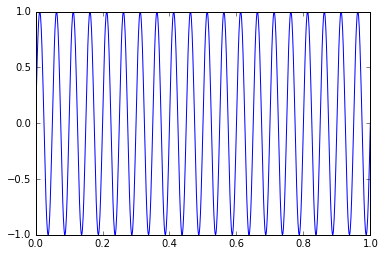

In [153]:
samp_rate = 1000
len_in_sec = 1
carrier_freq = 20  # Hz
t = np.linspace(0, 1, samp_rate * len_in_sec)
carrier = 1*np.sin(carrier_freq * 2 * np.pi * t)
plt.plot(t, carrier)

In [154]:
zero_crossings = np.where(np.diff(np.sign(carrier)))[0]

In [155]:
zero_crossings

array([  0,  24,  49,  74,  99, 124, 149, 174, 199, 224, 249, 274, 299,
       324, 349, 374, 399, 424, 449, 474, 499, 524, 549, 574, 599, 624,
       649, 674, 699, 724, 749, 774, 799, 824, 849, 874, 899, 924, 949, 974])

In [156]:
len(zero_crossings)

40

In [157]:
# Note that in a single wave cycle, there will be 2 zero crossings
frequency_detected = len(zero_crossings) / 2
frequency_detected

20.0

**Excellent! So using zero-crossing detection, we accurately determined the frequency to be 20Hz**

### FSK Demodulation with Multiplying by prospective frequencies

To try to determine the frequency, we can just take the dot product of a number of prospective frequencies, and see which has the largest dot product, which should correspond to the closest approximation of the frequency.

In [158]:
hz_10 = 1*np.sin(10 * 2 * np.pi * t)
hz_20 = 1*np.sin(20 * 2 * np.pi * t)
hz_30 = 1*np.sin(30 * 2 * np.pi * t)
hz_40 = 1*np.sin(40 * 2 * np.pi * t)

In [159]:
[np.dot(carrier, hz_10), np.dot(carrier, hz_20), np.dot(carrier, hz_30), np.dot(carrier, hz_40)]

[3.4227828904498381e-14,
 499.50000000000006,
 -5.1039034110189618e-14,
 -1.2802259252708836e-15]

** Success. The 20Hz dot product is clearly much larger than the 10, 20, or 40Hz dot products, indicating the frequency is 20Hz. **

It's worth noting, however, that if the frequency is just a bit off, the dot product is still near zero, so there's not a lot of room for error in terms of the frequency with this approach. Only 0.5Hz off has a near-zero dot product.

In [160]:
[np.dot(carrier, 1*np.sin(freq * 2 * np.pi * t)) for freq in [19.5, 19.6, 19.7, 19.8, 19.9, 20]]

[-5.3083232254280688e-13,
 117.99304872790121,
 253.91777912175343,
 379.9246442915134,
 468.44184940090764,
 499.50000000000006]

#### Relationship between frequency difference and dot product?

Out of curiosity, let's graph the <a href="#frequency_diff_to_dot_product">relationship</a> between the difference in the frequencies and the dot product...

In [161]:
def dot_between_freqs(f1, f2):
    t = np.linspace(0, 1, samp_rate * len_in_sec)
    f1_samples = 1*np.sin(f1 * 2 * np.pi * t)
    f2_samples = 1*np.sin(f2 * 2 * np.pi * t)
    return np.dot(f1_samples, f2_samples)

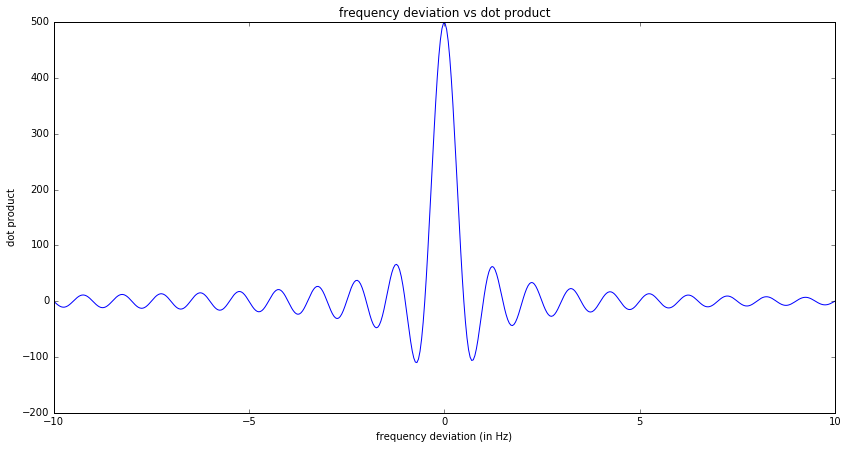

In [162]:
center_freq = 20
frequency_diffs = np.linspace(-10, 10, 500)
dots = [dot_between_freqs(center_freq, center_freq+d) for d in frequency_diffs]
setup_graph(title='frequency deviation vs dot product', x_label='frequency deviation (in Hz)', y_label='dot product', fig_size=(14,7))
plt.plot(frequency_diffs, dots)

Interesting! So it looks like a reflected damped sine wave. Now, does the variation in the dot product change based on absolute deviation from the center frequency, or is it based on percentage? Let's try a higher frequency with the same deviations...

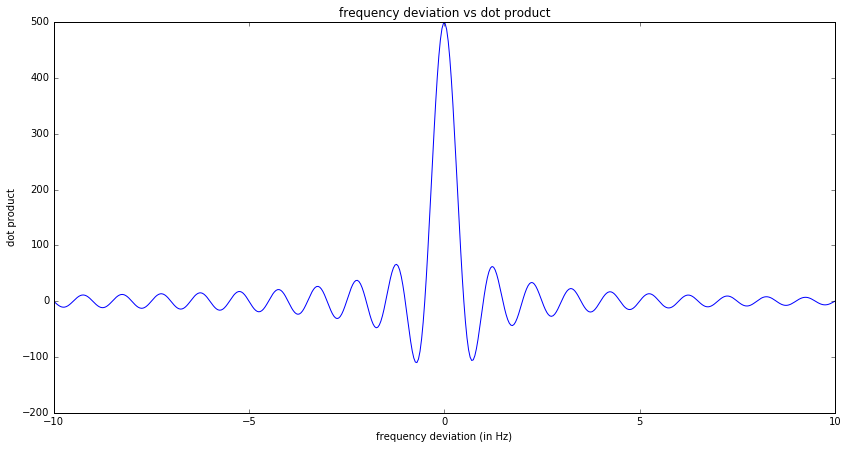

In [163]:
center_freq = 20000
frequency_diffs = np.linspace(-10, 10, 500)
dots = [dot_between_freqs(center_freq, center_freq+d) for d in frequency_diffs]
setup_graph(title='frequency deviation vs dot product', x_label='frequency deviation (in Hz)', y_label='dot product', fig_size=(14,7))
plt.plot(frequency_diffs, dots)

So it looks like the dot product varies as you move away from the center frequency purely based on absolute difference in Hz, rather than based on percentage of deviation (relative to the frequency).

### FSK Demodulation with FFT

The above method is kind of like a manual FFT. Let's see how the normal FFT fares.

/usr/local/lib/python3.5/site-packages/numpy/core/numeric.py:482: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


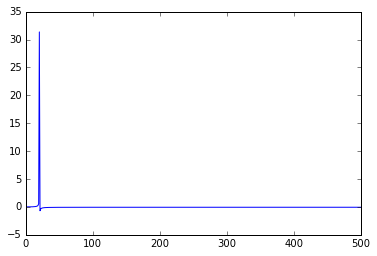

In [164]:
fft_output = np.fft.rfft(carrier)
plt.plot(fft_output)

In [165]:
len(carrier)

1000

In [166]:
[np.abs(fft_output[10]), np.abs(fft_output[20]), np.abs(fft_output[30])]

[0.66478821542671451, 499.41979981400442, 1.2033257365804482]

** Just as with the manual wave dot products above, you can see that the FFT output corresponding to 20Hz is the largest, indicating the wave is 20Hz. **

/usr/local/lib/python3.5/site-packages/numpy/core/numeric.py:482: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


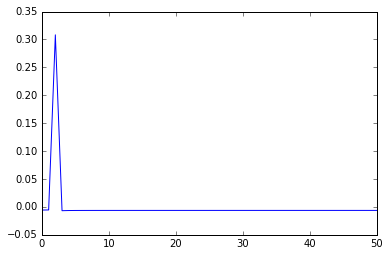

In [167]:
fft_output100 = np.fft.rfft(carrier, n=100)
plt.plot(fft_output100)

In [168]:
[np.abs(fft_output100[1]), np.abs(fft_output100[2]), np.abs(fft_output100[3])]

[0.066842540429641412, 49.974752647736054, 0.12030393547331324]

## FSK Modulation

Now that we've got some ideas for demodulating fsk, let's do some freakin' modulation!

### First, how do we increase the frequency of a wave?

For starters, let's just try doubling the frequency of the carrier wave. What mathematical operation can we use to double a wave's frequency? Well, going back to high school trigonometric identities, `sin(2x) = 2*sin(x)*cos(x)`. **So if our starting wave is `sin(x)` and we want to double it's frequency, we can just multiply it by `2*cos(x)`.**

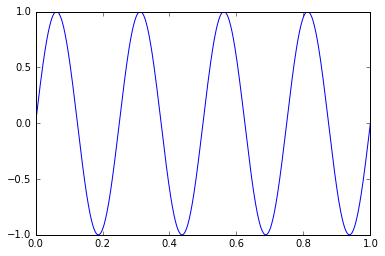

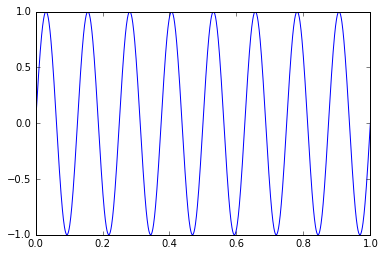

In [169]:
t = np.linspace(0, 1, samp_rate * len_in_sec)
hz_4 = 1*np.sin(4 * 2 * np.pi * t)
hz_8 = hz_4 * (2 * np.cos(4 * 2 * np.pi * t))
plt.plot(t, hz_4)
plt.show()
plt.plot(t, hz_8)
plt.show()

Interesting, so just multiplying by `2*cos(x)` doubles the frequency. Or, to think of it another way, just multiplying by a 90-degree phase-shifted wave of the same frequency (`cos(x)`... or as it could alternatively be called, `sin((pi/2)-x)`) doubles the frequency of a wave, but when the frequency doubles, the amplitude halves, and we have to do a scalar doubling in order to restore the original amplitude.

So let's now try to use this to modulate a carrier wave...

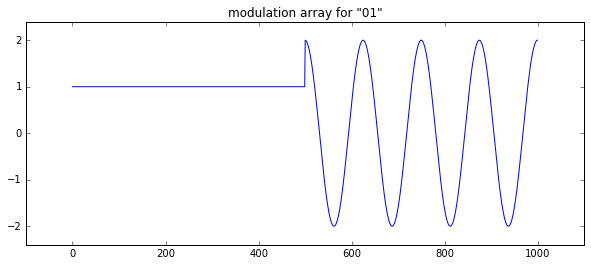

In [170]:
samp_rate = 1000  # samples/second
len_in_sec = 1
space_freq = 8  # Hz
t = np.linspace(0, 1, samp_rate * len_in_sec)
carrier = np.sin(space_freq * 2 * np.pi * t)

# Note: in FSK venaculare, "space" represents 0 and "mark" 1.
mark_multiplier_array = 2*np.cos(space_freq * 2 * np.pi * t)
modulation_array = np.array([1]*500 + [i for i in mark_multiplier_array[500:]])

setup_graph(title='modulation array for "01"', fig_size=(10,4))
plt.plot(modulation_array)
plt.margins(0.1)

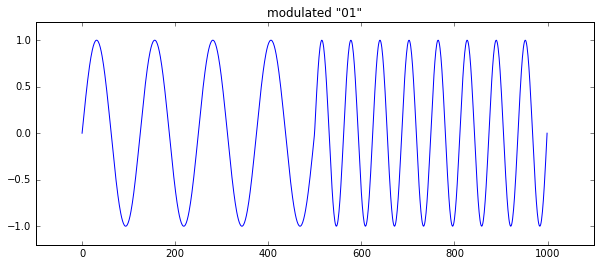

In [171]:
setup_graph(title='modulated "01"', fig_size=(10,4))
plt.plot(carrier * modulation_array)
plt.margins(0.1)

Excellent, so that worked well.

#### An easier approach

Another simpler way to do FSK modulation could be to just calculate arrays for each of the different frequencies, and then just concatenate those arrays together. In this case, we wouldn't really be modulating a "carrier" wave so much as building the modulated wave, one bit-worth at a time.

Let's try that approach...

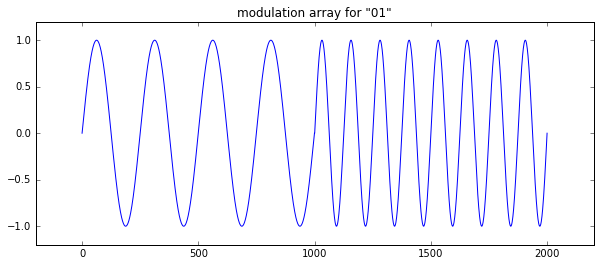

In [172]:
samp_rate = 1000  # samples/second
len_in_sec = 1
space_freq = 8  # Hz ("space" = "0")
mark_freq = 16  # Hz ("mark" = "1")
t = np.linspace(0, .5, samp_rate * len_in_sec)
space = np.sin(space_freq * 2 * np.pi * t)
mark = np.sin(mark_freq * 2 * np.pi * t)
modulated_01 = np.append(space, mark)

setup_graph(title='modulation array for "01"', fig_size=(10,4))
plt.plot(modulated_01)
plt.margins(0.1)

As can be seen, the results are practically equivalent, and this later approach is much less computationally intensive (as it mostly just entails memcpy's).

So let's now build a general FSK algorithm using this approach.

### General FSK algorithm

Let's start with BFSK (only 2 tones)...

In [173]:
def bfsk_modulate(bit_array, space_freq, mark_freq, baud, sample_rate):
    seconds_per_bit = 1 / baud
    samples_per_bit = sample_rate * seconds_per_bit
    t = np.linspace(0, seconds_per_bit, samples_per_bit)
    space = np.sin(space_freq * 2 * np.pi * t)
    mark = np.sin(mark_freq * 2 * np.pi * t)
    signal = np.array([])
    for bit in bit_array:
        if bit == 0:
            signal = np.append(signal, space)
        elif bit == 1:
            signal = np.append(signal, mark)
    return signal

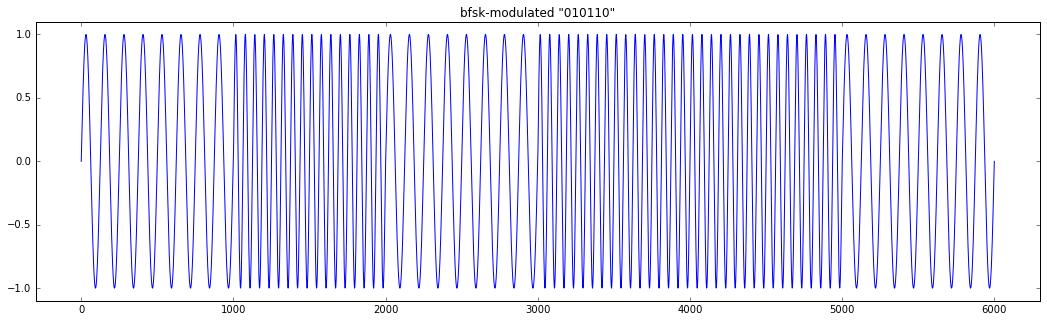

In [174]:
sig_010110 = bfsk_modulate([0,1,0,1,1,0], 8, 16, 1, 1000)
setup_graph(title='bfsk-modulated "010110"', fig_size=(18,5))
plt.plot(sig_010110)
plt.margins(0.05)

**Success!**